Title: Reproduction of Spatial Accessibility of COVID-19 Healthcare Resources in Illinois
---

**Reproduction of**: Rapidly measuring spatial accessibility of COVID-19 healthcare resources: a case study of Illinois, USA

Original study *by* Kang, J. Y., A. Michels, F. Lyu, Shaohua Wang, N. Agbodo, V. L. Freeman, and Shaowen Wang. 2020. Rapidly measuring spatial accessibility of COVID-19 healthcare resources: a case study of Illinois, USA. International Journal of Health Geographics 19 (1):1–17. DOI:[10.1186/s12942-020-00229-x](https://ij-healthgeographics.biomedcentral.com/articles/10.1186/s12942-020-00229-x).

Reproduction Authors: Joe Holler, Derrick Burt, Kufre Udoh, with contributions from Peter Kedron, Drew An-Pham, William Procter, and the Spring 2021/Fall 2023 Open Source GIScience classs at Middlebury

Reproduction Materials Available at: [github.com/HEGSRR/RPr-Kang-2020](https://github.com/HEGSRR/RPr-Kang-2020)

Created: `2021-06-01`
Revised: `2023-12-4`

### Original Study Design

The original Kang et al.(2020) investigates access to COVID-19 healthcare resources in Chicago using a network analysis and service ratio approach.  They combine and analyze data on the the point locations of hospitals, hospital capacity (specifically ICU beds and ventilators), a road network of Chicago, COVID-19 cases, and census population data on at-risk individuals (over age 50).  Specifically, they generate hospital catchment areas in the vicinity of each hospital using a road network and estimated travel time to each hospital; these are effectively service polygons for each hospital, which are each one is for a specific driving distance from each hospital.   Centroid points are determined for population and COVID-19 case data (for each zip code).  A spatial join (joining the population point data to the each service polygon) is then used to calculate a weighted service ratio for each hospital catchment area.  This data is then unioned to a "raster" grid of hexagons, to produce a continuous map of service ratios in Chicago...which is effectively an accessibility measure.  This accessibility measure is weighted on a [0,1] scale, where 1 is the greatest accessibility to critical COVID-19 healthcare resources (ICU beds or ventilators).  The output maps of this study compare spatial accessibility measures for COVID-19 patients to those of population at risk, and identifes which geographic areas need additional healthcare resources to improve access. 

### Reproduction Study Design

This reproduction seeks to test two amendments to the original methodology.

1. Improve speed limit information. The current network analysis methodology uses known speed limits on roads in the network, and employs a simple distance to hospital divided by the speed limit to calculate the travel distance to the nearest hospital, which informs the spatial extent of the service area polygons for each hospital.  However, for roads that do not have a known speed limit in the data (of which there are many), the original authors arbitrarily assign a speed limit of 35mph, even though this may not be realistic (especially for highways).  Similarly, some roads have a range of speed limits.  Thus, we believe that there is a better methodology to computing travel time.  To do this, plan to replace the network_setting function with use of the osmnx.speed module. Note how this changes the speed limit data checks before & after network_setting. To gauge the effect of making this methodological change, we plan to compare graphs of hospital catchment areas between the two methods, and also create a difference map of the hexagon grid to illustrate the changes that this new methodology has.

2. Improve translation from hospital catchments into hexagons by employing Area-Weighted Reaggregation.  Rather than use as simple 50% overlap threshold to determine whether service polygon fragments inform the value of a polygon, we will take a more holistic approach and better weight the role of each catchment area on a given hexagon.  For instance, if 3 catchment areas overlap the same hexagon, but all have different overlap amounts.  To do this, focus on the overlap_calc function. Try commenting every line of this function with its purpose before changing anything. To gauge the impact of this methodological change, again, we plan to compare graphs of hospital catchment areas between the two methods, and also create a difference map of the hexagon grid to illustrate the changes that this new methodology has.  We will also do a correlation analysis of these two methodologies of hexagons.



### Original Data
To perform the ESFCA method, three types of data are required, as follows: (1) road network, (2) population, and (3) hospital information. The road network can be obtained from the [OpenStreetMap Python Library, called OSMNX](https://github.com/gboeing/osmnx). The population data is available on the [American Community Survey](https://data.census.gov/cedsci/deeplinks?url=https%3A%2F%2Ffactfinder.census.gov%2F&tid=GOVSTIMESERIES.CG00ORG01). Lastly, hospital information is also publically available on the [Homelanad Infrastructure Foundation-Level Data](https://hifld-geoplatform.opendata.arcgis.com/datasets/hospitals?geometry=-94.504%2C40.632%2C-80.980%2C43.486).

### Modules
Import necessary libraries to run this model.
See `environment.yml` for the library versions used for this analysis.

In [1]:
# Import modules
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import osmnx as ox
import re
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
import folium
import itertools
import os
import time
import warnings
import IPython
import requests
from IPython.display import display, clear_output

warnings.filterwarnings("ignore")
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.22.0
pandas==1.3.5
geopandas==0.10.2
networkx==2.6.3
osmnx==1.1.2
re==2.2.1
folium==0.12.1.post1
IPython==8.3.0
requests==2.27.1


## Check Directories

Because we have restructured the repository for replication, we need to check our working directory and make necessary adjustments.

In [2]:
# Check working directory
os.getcwd()

'/home/jovyan/work/RPr-Kang-2020/procedure/code'

In [3]:
# Use to set work directory properly
if os.path.basename(os.getcwd()) == 'code':
    os.chdir('../../')
os.getcwd()

'/home/jovyan/work/RPr-Kang-2020'

## Load and Visualize Data

### Population and COVID-19 Cases Data by County

*'Cases' column is coming in as 'Unnamed_0' --> easy to rename but this probably should be reportede to the original authors*

If you would like to use the data generated from the pre-processing scripts, use the following code:

```py
covid_data = gpd.read_file('./data/raw/public/Pre-Processing/covid_pre-processed.shp')
atrisk_data = gpd.read_file('./data/raw/public/Pre-Processing/atrisk_pre-processed.shp')
```

In [4]:
# Read in at risk population data
atrisk_data = gpd.read_file('./data/raw/public/PopData/Illinois_Tract.shp')
atrisk_data.head()

,GEOID,STATEFP,COUNTYFP,TRACTCE,NAMELSAD,Pop,Unnamed_ 0,NAME,OverFifty,TotalPop,geometry
0,17091011700,17,091,011700,Census Tract 117,3688,588,"Census Tract 117, Kankakee County, Illinois",1135,3688,"POLYGON ((-87.88768 41.13594, -87.88764 41.136..."
1,17091011800,17,091,011800,Census Tract 118,2623,220,"Census Tract 118, Kankakee County, Illinois",950,2623,"POLYGON ((-87.89410 41.14388, -87.89400 41.143..."
2,17119400951,17,119,400951,Census Tract 4009.51,5005,2285,"Census Tract 4009.51, Madison County, Illinois",2481,5005,"POLYGON ((-90.11192 38.70281, -90.11128 38.703..."
3,17119400952,17,119,400952,Census Tract 4009.52,3014,2299,"Census Tract 4009.52, Madison County, Illinois",1221,3014,"POLYGON ((-90.09442 38.72031, -90.09360 38.720..."
4,17135957500,17,135,957500,Census Tract 9575,2869,1026,"Census Tract 9575, Montgomery County, Illinois",1171,2869,"POLYGON ((-89.70369 39.34803, -89.69928 39.348..."


In [5]:
# Read in covid case data
covid_data = gpd.read_file('./data/raw/public/PopData/Chicago_ZIPCODE.shp')
covid_data['cases'] = covid_data['cases']
covid_data.head()

,ZCTA5CE10,County,State,Join,ZONE,ZONENAME,FIPS,pop,cases,geometry
0,60660,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,43242,78,"POLYGON ((-87.65049 41.99735, -87.65029 41.996..."
1,60640,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,69715,117,"POLYGON ((-87.64645 41.97965, -87.64565 41.978..."
2,60614,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,71308,134,"MULTIPOLYGON (((-87.67703 41.91845, -87.67705 ..."
3,60712,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,12539,42,"MULTIPOLYGON (((-87.76181 42.00465, -87.76156 ..."
4,60076,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,31867,114,"MULTIPOLYGON (((-87.74782 42.01540, -87.74526 ..."


### Load Hospital Data

Note that 999 is treated as a "NULL"/"NA" so these hospitals are filtered out. This data contains the number of ICU beds and ventilators at each hospital.

In [6]:
# Read in hospital data
hospitals = gpd.read_file('./data/raw/public/HospitalData/Chicago_Hospital_Info.shp')
hospitals.head()

,FID,Hospital,City,ZIP_Code,X,Y,Total_Bed,Adult ICU,Total Vent,geometry
0,2,Methodist Hospital of Chicago,Chicago,60640,-87.671079,41.972800,145,36,12,MULTIPOINT (-87.67108 41.97280)
1,4,Advocate Christ Medical Center,Oak Lawn,60453,-87.732483,41.720281,785,196,64,MULTIPOINT (-87.73248 41.72028)
2,13,Evanston Hospital,Evanston,60201,-87.683288,42.065393,354,89,29,MULTIPOINT (-87.68329 42.06539)
3,24,AMITA Health Adventist Medical Center Hinsdale,Hinsdale,60521,-87.920116,41.805613,261,65,21,MULTIPOINT (-87.92012 41.80561)
4,25,Holy Cross Hospital,Chicago,60629,-87.690841,41.770001,264,66,21,MULTIPOINT (-87.69084 41.77000)


### Generate and Plot Map of Hospitals

In [7]:
# Plot hospital data
m = folium.Map(location=[41.85, -87.65], tiles='cartodbpositron', zoom_start=10)
for i in range(0, len(hospitals)):
    folium.CircleMarker(
      location=[hospitals.iloc[i]['Y'], hospitals.iloc[i]['X']],
      popup="{}{}\n{}{}\n{}{}".format('Hospital Name: ',hospitals.iloc[i]['Hospital'],
                                      'ICU Beds: ',hospitals.iloc[i]['Adult ICU'],
                                      'Ventilators: ', hospitals.iloc[i]['Total Vent']),
      radius=5,
      color='blue',
      fill=True,
      fill_opacity=0.6,
      legend_name = 'Hospitals'
    ).add_to(m)
legend_html =   '''<div style="position: fixed; width: 20%; heigh: auto;
                            bottom: 10px; left: 10px;
                            solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; Legend<br>'''

m

### Load and Plot Hexagon Grids (500-meter resolution)

<AxesSubplot:>

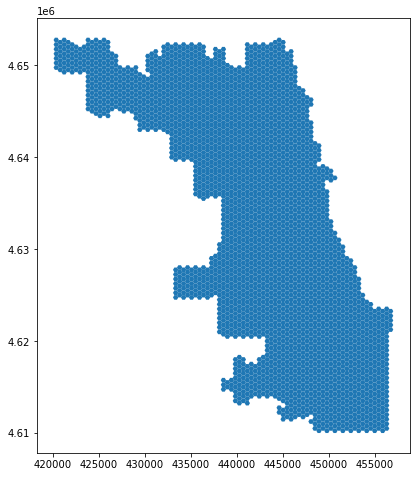

In [8]:
# Read in and plot grid file for Chicago
grid_file = gpd.read_file('./data/raw/public/GridFile/Chicago_Grid.shp')
grid_file.plot(figsize=(8,8))

### Load the Buffered Road Network (15 miles ~ 24140.2 meters)

If `Chicago_Network_Buffer.graphml` does not already exist, this cell will query the road network from OpenStreetMap.  

Each of the road network code blocks may take a few mintues to run.

In [9]:
%%time
# To create a new graph from OpenStreetMap, delete or rename data/raw/private/Chicago_Network_Buffer.graphml 
# (if it exists), and set OSM to True 
OSM = True

# if buffered street network is not saved, and OSM is preferred, # generate a new graph from OpenStreetMap and save it
if not os.path.exists("./data/raw/private/Chicago_Network_Buffer.graphml") and OSM:
    print("Loading buffered Chicago road network from OpenStreetMap. Please wait... runtime may exceed 9min...", flush=True)
    G = ox.graph_from_place('Chicago', network_type='drive', buffer_dist=24140.2) 
    print("Saving Chicago road network to raw/private/Chicago_Network_Buffer.graphml. Please wait...", flush=True)
    ox.save_graphml(G, './data/raw/private/Chicago_Network_Buffer.graphml')
    print("Data saved.")

# otherwise, if buffered street network is not saved, download graph from the OSF project
elif not os.path.exists("./data/raw/private/Chicago_Network_Buffer.graphml"):
    print("Downloading buffered Chicago road network from OSF...", flush=True)
    url = 'https://osf.io/download/z8ery/'
    r = requests.get(url, allow_redirects=True)
    print("Saving buffered Chicago road network to file...", flush=True)
    open('./data/raw/private/Chicago_Network_Buffer.graphml', 'wb').write(r.content)

# if the buffered street network is already saved, load it
if os.path.exists("./data/raw/private/Chicago_Network_Buffer.graphml"):
    print("Loading buffered Chicago road network from raw/private/Chicago_Network_Buffer.graphml. Please wait...", flush=True)
    G = ox.load_graphml('./data/raw/private/Chicago_Network_Buffer.graphml') 
    print("Data loaded.") 
else:
    print("Error: could not load the road network from file.")

Loading buffered Chicago road network from raw/private/Chicago_Network_Buffer.graphml. Please wait...
Data loaded.
CPU times: user 55.1 s, sys: 3.83 s, total: 58.9 s
Wall time: 58.7 s


### Plot the Road Network

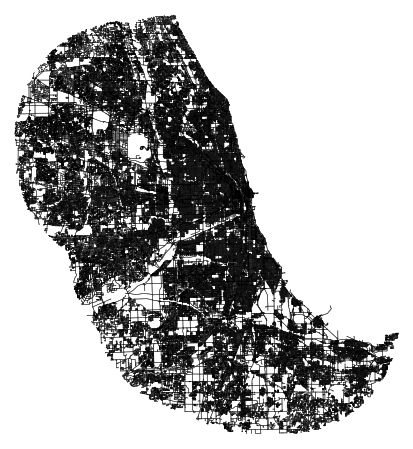

CPU times: user 1min 8s, sys: 646 ms, total: 1min 9s
Wall time: 1min 9s


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [10]:
%%time
ox.plot_graph(G, node_size = 1, bgcolor = 'white', node_color = 'black', edge_color = "#333333", node_alpha = 0.5, edge_linewidth = 0.5)

#### Check speed limit values

Display all the unique speed limit values and count how many network edges (road segments) have each value.
We will compare this to our cleaned network later.

In [11]:
%%time
# Turn nodes and edges into geodataframes
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# Get unique counts of road segments for each speed limit
print(edges['maxspeed'].value_counts())
print(str(len(edges)) + " edges in graph")

# can we also visualize highways / roads with higher speed limits to check accuracy?
# the code above converts the graph into an edges geodataframe, which could theoretically be filtered
# by fast road segments and mapped, e.g. in folium

nodes

25 mph                        4793
30 mph                        3555
35 mph                        3364
40 mph                        2093
45 mph                        1418
20 mph                        1155
55 mph                         614
60 mph                         279
50 mph                         191
40                              79
15 mph                          76
70 mph                          71
65 mph                          54
10 mph                          38
[40 mph, 45 mph]                27
[30 mph, 35 mph]                26
45,30                           24
[40 mph, 35 mph]                22
70                              21
25                              20
[55 mph, 45 mph]                16
25, east                        14
[45 mph, 35 mph]                13
[30 mph, 25 mph]                10
[45 mph, 50 mph]                 8
50                               8
[40 mph, 30 mph]                 7
[35 mph, 25 mph]                 6
[55 mph, 60 mph]    

,y,x,osmid,highway,ref,geometry
osmid,,,,,,
261095436,42.105710,-87.902373,261095436,NaN,NaN,POINT (-87.90237 42.10571)
261095437,42.105404,-87.901983,261095437,NaN,NaN,POINT (-87.90198 42.10540)
261095439,42.105109,-87.901586,261095439,NaN,NaN,POINT (-87.90159 42.10511)
261095445,42.104685,-87.902326,261095445,turning_circle,NaN,POINT (-87.90233 42.10468)
261095446,42.104630,-87.901830,261095446,NaN,NaN,POINT (-87.90183 42.10463)
...,...,...,...,...,...,...
4332716015,42.026807,-87.806467,4332716015,NaN,NaN,POINT (-87.80647 42.02681)
2293235696,41.794604,-87.627795,2293235696,NaN,NaN,POINT (-87.62780 41.79460)
237502450,41.466574,-87.667652,237502450,NaN,NaN,POINT (-87.66765 41.46657)


In [12]:
edges.head()

osmid      highway oneway  length name  \
u         v         key                                              
261095436 261095437 0    24067717  residential  False  46.873  NaN   
261095437 261095439 0    24067717  residential  False  46.317  NaN   
          261095436 0    24067717  residential  False  46.873  NaN   
          261109275 0    24069424  residential  False  34.892  NaN   
          261109274 0    24069424  residential  False  47.866  NaN   

                                                                  geometry  \
u         v         key                                                      
261095436 261095437 0    LINESTRING (-87.90237 42.10571, -87.90198 42.1...   
261095437 261095439 0    LINESTRING (-87.90198 42.10540, -87.90159 42.1...   
          261095436 0    LINESTRING (-87.90198 42.10540, -87.90237 42.1...   
          261109275 0    LINESTRING (-87.90198 42.10540, -87.90227 42.1...   
          261109274 0    LINESTRING (-87.90198 42.10540, -87.90156 42.1...   

                        lanes  ref bridge maxspeed access service tunnel  \
u         v         key                                                    
261095436 261095437 0     NaN  NaN    NaN      NaN    NaN     NaN    NaN   
261095437 261095439 0     NaN  NaN    NaN      NaN    NaN     NaN    NaN   
          261095436 0     NaN  NaN    NaN      NaN    NaN     NaN    NaN   
          261109275 0     NaN  NaN    NaN      NaN    NaN     NaN    NaN   
          261109274 0     NaN  NaN    NaN      NaN    NaN     NaN    NaN   

                        junction width area  
u         v         key                      
261095436 261095437 0        NaN   NaN  NaN  
261095437 261095439 0        NaN   NaN  NaN  
          261095436 0        NaN   NaN  NaN  
          261109275 0        NaN   NaN  NaN  
          261109274 0        NaN   NaN  NaN

### network_setting function

Cleans the OSMNX network to work better with drive-time analysis.

First, we remove all nodes with 0 outdegree because any hospital assigned to such a node would be unreachable from everywhere. Next, we remove small (under 10 node) *strongly connected components* to reduce erroneously small ego-centric networks. Lastly, we ensure that the max speed is set and in the correct units before calculating time.

Args:

* network: OSMNX network for the spatial extent of interest

Returns:

* OSMNX network: cleaned OSMNX network for the spatial extent

In [13]:
#view all highway types
print(edges['highway'].value_counts())

residential                     296481
secondary                        30909
tertiary                         29216
primary                          19277
motorway_link                     2322
unclassified                      1840
motorway                          1449
trunk                              843
primary_link                       833
secondary_link                     356
living_street                      238
trunk_link                         157
tertiary_link                      121
[residential, unclassified]         69
[tertiary, residential]             66
[secondary, primary]                15
[secondary, tertiary]               10
[motorway, motorway_link]            6
[tertiary, unclassified]             6
[motorway, trunk]                    4
[residential, living_street]         4
[secondary, secondary_link]          3
busway                               2
[motorway, primary]                  2
[tertiary, motorway_link]            2
emergency_bay            

In [14]:
# two things about this function:
# 1) the work to remove nodes is hardly worth it now that OSMnx cleans graphs by default
# the function is now only pruning < 300 nodes
# 2) try using the OSMnx speed module for setting speeds, travel times
# https://osmnx.readthedocs.io/en/stable/user-reference.html#module-osmnx.speed
# just be careful about units of speed and time!
# the remainder of this code expects 'time' to be measured in minutes

# def network_setting(network):
#     _nodes_removed = len([n for (n, deg) in network.out_degree() if deg ==0])
#     network.remove_nodes_from([n for (n, deg) in network.out_degree() if deg ==0])
#     for component in list(nx.strongly_connected_components(network)):
#         if len(component)<10:
#             for node in component:
#                 _nodes_removed+=1
#                 network.remove_node(node)
#     for u, v, k, data in tqdm(G.edges(data=True, keys=True),position=0):
#         if 'maxspeed' in data.keys():
#             speed_type = type(data['maxspeed'])
#             if (speed_type==str):
#                 # Add in try/except blocks to catch maxspeed formats that don't fit Kang et al's cases
#                 try:
#                     if len(data['maxspeed'].split(','))==2:
#                         data['maxspeed_fix']=float(data['maxspeed'].split(',')[0])                  
#                     elif data['maxspeed']=='signals':
#                         data['maxspeed_fix']=30.0 # drive speed setting as 35 miles
#                     else:
#                         data['maxspeed_fix']=float(data['maxspeed'].split()[0])
#                 except:
#                     data['maxspeed_fix']=30.0 #miles
#             else:
#                 try:
#                     data['maxspeed_fix']=float(data['maxspeed'][0].split()[0])
#                 except:
#                     data['maxspeed_fix']=30.0 #miles
#         else:
#             data['maxspeed_fix']=30.0 #miles
#         data['maxspeed_meters'] = data['maxspeed_fix']*26.8223 # convert mile per hour to meters per minute
#         data['time'] = float(data['length'])/ data['maxspeed_meters'] # meters / meters per minute = minutes
#     print("Removed {} nodes ({:2.4f}%) from the OSMNX network".format(_nodes_removed, _nodes_removed/float(network.number_of_nodes())))
#     print("Number of nodes: {}".format(network.number_of_nodes()))
#     print("Number of edges: {}".format(network.number_of_edges()))    
#     return(network)

# Imputes edge speed in kilometers per hour to roads that are missing speed limits


#    _nodes_removed = len([n for (n, deg) in network.out_degree() if deg ==0])
#    network.remove_nodes_from([n for (n, deg) in network.out_degree() if deg ==0])
#    for component in list(nx.strongly_connected_components(network)):
#        if len(component)<10:
#            for node in component:
#                _nodes_removed+=1
#                network.remove_node(node)

#    print("Removed {} nodes ({:2.4f}%) from the OSMNX network".format(_nodes_removed, _nodes_removed/float(network.number_of_nodes())))
#    print("Number of nodes: {}".format(network.number_of_nodes()))
#    print("Number of edges: {}".format(network.number_of_edges()))
#    return(network)

def network_setting(network):
    _nodes_removed = len([n for (n, deg) in network.out_degree() if deg ==0])
    network.remove_nodes_from([n for (n, deg) in network.out_degree() if deg ==0])
    for component in list(nx.strongly_connected_components(network)):
        if len(component)<10:
            for node in component:
                _nodes_removed+=1
                network.remove_node(node)
    ox.speed.add_edge_speeds(network)
    ox.speed.add_edge_travel_times(network)
    print("Removed {} nodes ({:2.4f}%) from the OSMNX network".format(_nodes_removed, _nodes_removed/float(network.number_of_nodes())))
    print("Number of nodes: {}".format(network.number_of_nodes()))
    print("Number of edges: {}".format(network.number_of_edges()))
    return network

#print(G)

### Preprocess the Network using network_setting

In [15]:
%%time
# G, hospitals, grid_file, pop_data = file_import (population_dropdown.value)
G = network_setting(G)

# Create point geometries for each node in the graph, to make constructing catchment area polygons easier
for node, data in G.nodes(data=True):
    data['geometry']=Point(data['x'], data['y'])
# Modify code to react to processor dropdown (got rid of file_import function)

Removed 274 nodes (0.0019%) from the OSMNX network
Number of nodes: 142044
Number of edges: 383911
CPU times: user 52.4 s, sys: 837 ms, total: 53.3 s
Wall time: 53 s


#### Re-check speed limit values

Display all the unique speed limit values and count how many network edges (road segments) have each value.
Compare to the previous results.

In [16]:
%%time
## Get unique counts of speed limits for each road network...after imputing
# Turn nodes and edges in geodataframes
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# Convert from kph to mph
#edges['speed_mph'] = edges['speed_kph']*0.62137119223733
# Count
#print(edges['speed_mph'].value_counts())
print(str(len(edges)) + " edges in graph")
print(edges['travel_time'].value_counts()) #in seconds

383911 edges in graph
9.3      14185
9.2      11922
18.6      8012
9.4       7209
18.5      6608
         ...  
199.5        1
115.5        1
145.7        1
122.3        1
136.9        1
Name: travel_time, Length: 1183, dtype: int64
CPU times: user 48.2 s, sys: 251 ms, total: 48.5 s
Wall time: 48.3 s


## "Helper" Functions

The functions below are needed for our analysis later, let's take a look!

### hospital_setting

Finds the nearest network node for each hospital.

Args:

* hospital: GeoDataFrame of hospitals
* G: OSMNX network

Returns:

* GeoDataFrame of hospitals with info on nearest network node

In [17]:
def hospital_setting(hospitals, G):
    # Create an empty column 
    hospitals['nearest_osm']=None
    # Append the neaerest osm column with each hospitals neaerest osm node
    for i in tqdm(hospitals.index, desc="Find the nearest network node from hospitals", position=0):
        hospitals['nearest_osm'][i] = ox.get_nearest_node(G, [hospitals['Y'][i], hospitals['X'][i]], method='euclidean') # find the nearest node from hospital location
    print ('hospital setting is done')
    return(hospitals)

### pop_centroid

Converts geodata to centroids

Args:

* pop_data: a GeodataFrame
* pop_type: a string, either "pop" for general population or "covid" for COVID-19 case data

Returns:

* GeoDataFrame of centroids with population data

In [18]:
def pop_centroid (pop_data, pop_type):
    pop_data = pop_data.to_crs({'init': 'epsg:4326'})
    # If pop is selected in dropdown, select at risk pop where population is greater than 0
    if pop_type =="pop":
        pop_data=pop_data[pop_data['OverFifty']>=0]
    # If covid is selected in dropdown, select where covid cases are greater than 0
    if pop_type =="covid":
        pop_data=pop_data[pop_data['cases']>=0]
    pop_cent = pop_data.centroid # it make the polygon to the point without any other information
    # Convert to gdf
    pop_centroid = gpd.GeoDataFrame()
    i = 0
    for point in tqdm(pop_cent, desc='Pop Centroid File Setting', position=0):
        if pop_type== "pop":
            pop = pop_data.iloc[i]['OverFifty']
            code = pop_data.iloc[i]['GEOID']
        if pop_type =="covid":
            pop = pop_data.iloc[i]['cases']
            code = pop_data.iloc[i].ZCTA5CE10
        pop_centroid = pop_centroid.append({'code':code,'pop': pop,'geometry': point}, ignore_index=True)
        i = i+1
    return(pop_centroid)

### djikstra_cca_polygons

Function written by Joe Holler + Derrick Burt. It is a more efficient way to calculate distance-weighted catchment areas for each hospital. The algorithm runs quicker than the original one ("calculate_catchment_area"). It first creates a dictionary (with a node and its corresponding drive time from the hospital) of all nodes within a 30 minute drive time (using single_cource_dijkstra_path_length function). From here, two more dictionaries are constructed by querying the original one. From this dictionaries, single part convex hulls are created for each drive time interval and appended into a single list (one list with 3 polygon geometries). Within the list, the polygons are differenced from each other to produce three catchment areas.

Args:
* G: cleaned network graph *with node point geometries attached*
* nearest_osm: A unique nearest node ID calculated for a single hospital
* distances: 3 distances (in drive time) to calculate catchment areas from
* distance_unit: unit to calculate (time)

Returns:
* A list of 3 diffrenced (not-overlapping) catchment area polygons (10 min poly, 20 min poly, 30 min poly)

In [19]:
def dijkstra_cca_polygons(G, nearest_osm, distances, distance_unit = "travel_time"):
    
    '''
    
    Before running: must assign point geometries to street nodes
    
    # create point geometries for the entire graph
    for node, data in G.nodes(data=True):
    data['geometry']=Point(data['x'], data['y'])
    
    '''
    
    ## CREATE DICTIONARIES
    # create dictionary of nearest nodes
    nearest_nodes_30 = nx.single_source_dijkstra_path_length(G, nearest_osm, distances[2], distance_unit) # creating the largest graph from which 10 and 20 minute drive times can be extracted from
    
    # extract values within 20 and 10 (respectively) minutes drive times
    nearest_nodes_20 = dict()
    nearest_nodes_10 = dict()
    for key, value in nearest_nodes_30.items():
        if value <= distances[1]:
            nearest_nodes_20[key] = value
        if value <= distances[0]:
            nearest_nodes_10[key] = value
    
    ## CREATE POLYGONS FOR 3 DISTANCE CATEGORIES (10 min, 20 min, 30 min)
    # 30 MIN
    # If the graph already has a geometry attribute with point data,
    # this line will create a GeoPandas GeoDataFrame from the nearest_nodes_30 dictionary
    points_30 = gpd.GeoDataFrame(gpd.GeoSeries(nx.get_node_attributes(G.subgraph(nearest_nodes_30), 'geometry')))

    # This line converts the nearest_nodes_30 dictionary into a Pandas data frame and joins it to points
    # left_index=True and right_index=True are options for merge() to join on the index values
    points_30 = points_30.merge(pd.Series(nearest_nodes_30).to_frame(), left_index=True, right_index=True)

    # Re-name the columns and set the geodataframe geometry to the geometry column
    points_30 = points_30.rename(columns={'0_x':'geometry','0_y':'z'}).set_geometry('geometry')

    # Create a convex hull polygon from the points
    polygon_30 = gpd.GeoDataFrame(gpd.GeoSeries(points_30.unary_union.convex_hull))
    polygon_30 = polygon_30.rename(columns={0:'geometry'}).set_geometry('geometry')
    
    # 20 MIN
    # Select nodes less than or equal to 20 mins (1200 secs)
    points_20 = points_30.query("z <= 1200")
    
    # Create a convex hull polygon from the points
    polygon_20 = gpd.GeoDataFrame(gpd.GeoSeries(points_20.unary_union.convex_hull))
    polygon_20 = polygon_20.rename(columns={0:'geometry'}).set_geometry('geometry')
    
    # 10 MIN
    # Select nodes less than or equal to 10 mins (600 secs)
    points_10 = points_30.query("z <= 600")
    
    # Create a convex hull polygon from the points
    polygon_10 = gpd.GeoDataFrame(gpd.GeoSeries(points_10.unary_union.convex_hull))
    polygon_10 = polygon_10.rename(columns={0:'geometry'}).set_geometry('geometry')
    
    # Create empty list and append polygons
    polygons = []
    
    # Append
    polygons.append(polygon_10)
    polygons.append(polygon_20)
    polygons.append(polygon_30)
    
    # Clip the overlapping distance ploygons (create two donuts + hole)
    for i in reversed(range(1, len(distances))):
        polygons[i] = gpd.overlay(polygons[i], polygons[i-1], how="difference")

    return polygons

### hospital_measure_acc (adjusted to incorporate dijkstra_cca_polygons)

Measures the effect of a single hospital on the surrounding area. (Uses `dijkstra_cca_polygons`)

Args:

* \_thread\_id: int used to keep track of which thread this is
* hospital: Geopandas dataframe with information on a hospital
* pop_data: Geopandas dataframe with population data
* distances: Distances in time to calculate accessibility for
* weights: how to weight the different travel distances

Returns:

* Tuple containing:
    * Int (\_thread\_id)
    * GeoDataFrame of catchment areas with key stats

In [20]:
def hospital_measure_acc (_thread_id, hospital, pop_data, distances, weights):
    # Create polygons
    polygons = dijkstra_cca_polygons(G, hospital['nearest_osm'], distances)
    
    # Calculate accessibility measurements
    num_pops = []
    for j in pop_data.index:
        point = pop_data['geometry'][j]
        # Multiply polygons by weights
        for k in range(len(polygons)):
            if len(polygons[k]) > 0: # To exclude the weirdo (convex hull is not polygon)
                if (point.within(polygons[k].iloc[0]["geometry"])):
                    num_pops.append(pop_data['pop'][j]*weights[k])  
    total_pop = sum(num_pops)
    for i in range(len(distances)):
        polygons[i]['time']=distances[i]
        polygons[i]['total_pop']=total_pop
        polygons[i]['hospital_icu_beds'] = float(hospital['Adult ICU'])/polygons[i]['total_pop'] # proportion of # of beds over pops in 10 mins
        polygons[i]['hospital_vents'] = float(hospital['Total Vent'])/polygons[i]['total_pop'] # proportion of # of beds over pops in 10 mins
        polygons[i].crs = { 'init' : 'epsg:4326'}
        polygons[i] = polygons[i].to_crs({'init':'epsg:32616'})
    print('{:.0f}'.format(_thread_id), end=" ", flush=True)
    return(_thread_id, [ polygon.copy(deep=True) for polygon in polygons ]) 

### measure_acc_par

Parallel implementation of accessibility measurement.

Args:

* hospitals: Geodataframe of hospitals
* pop_data: Geodataframe containing population data
* network: OSMNX street network
* distances: list of distances to calculate catchments for
* weights: list of floats to apply to different catchments
* num\_proc: number of processors to use.

Returns:

* Geodataframe of catchments with accessibility statistics calculated

In [21]:
def hospital_acc_unpacker(args):
    return hospital_measure_acc(*args)

# WHERE THE RESULTS ARE POOLED AND THEN REAGGREGATED
def measure_acc_par (hospitals, pop_data, network, distances, weights, num_proc = 4):
    catchments = []
    for distance in distances:
        catchments.append(gpd.GeoDataFrame())
    pool = mp.Pool(processes = num_proc)
    hospital_list = [ hospitals.iloc[i] for i in range(len(hospitals)) ]
    print("Calculating", len(hospital_list), "hospital catchments...\ncompleted number:", end=" ")
    results = pool.map(hospital_acc_unpacker, zip(range(len(hospital_list)), hospital_list, itertools.repeat(pop_data), itertools.repeat(distances), itertools.repeat(weights)))
    pool.close()
    results.sort()
    results = [ r[1] for r in results ]
    for i in range(len(results)):
        for j in range(len(distances)):
            catchments[j] = catchments[j].append(results[i][j], sort=False)
    return catchments

### overlap_calc

Calculates and aggregates accessibility statistics for one catchment on our grid file.

Args:

* \_id: thread ID
* poly: GeoDataFrame representing a catchment area
* grid_file: a GeoDataFrame representing our grids
* weight: the weight to applied for a given catchment
* service_type: the service we are calculating for: ICU beds or ventilators

Returns:

* Tuple containing:
    * thread ID
    * Counter object (dictionary for numbers) with aggregated stats by grid ID number

In [22]:
from collections import Counter
def overlap_calc(_id, poly, grid_file, weight, service_type):
    value_dict = Counter()
    if type(poly.iloc[0][service_type])!=type(None):           
        value = float(poly[service_type])*weight
        intersect = gpd.overlay(grid_file, poly, how='intersection')
        intersect['overlapped']= intersect.area
        intersect['percent'] = intersect['overlapped']/intersect['area']
        intersect=intersect[intersect['percent']>=0.5]
        intersect_region = intersect['id']
        for intersect_id in intersect_region:
            try:
                value_dict[intersect_id] +=value
            except:
                value_dict[intersect_id] = value
    return(_id, value_dict)

def overlap_calc_unpacker(args):
    return overlap_calc(*args)

### overlapping_function

Calculates how all catchment areas overlap with and affect the accessibility of each grid in our grid file.

Args:

* grid_file: GeoDataFrame of our grid
* catchments: GeoDataFrame of our catchments
* service_type: the kind of care being provided (ICU beds vs. ventilators)
* weights: the weight to apply to each service type
* num\_proc: the number of processors

Returns:

* Geodataframe - grid\_file with calculated stats

In [23]:
def overlapping_function (grid_file, catchments, service_type, weights, num_proc = 4):
    grid_file[service_type]=0
    pool = mp.Pool(processes = num_proc)
    acc_list = []
    for i in range(len(catchments)):
        acc_list.extend([ catchments[i][j:j+1] for j in range(len(catchments[i])) ])
    acc_weights = []
    for i in range(len(catchments)):
        acc_weights.extend( [weights[i]]*len(catchments[i]) )
    results = pool.map(overlap_calc_unpacker, zip(range(len(acc_list)), acc_list, itertools.repeat(grid_file), acc_weights, itertools.repeat(service_type)))
    pool.close()
    results.sort()
    results = [ r[1] for r in results ]
    service_values = results[0]
    for result in results[1:]:
        service_values+=result
    for intersect_id, value in service_values.items():
        grid_file.loc[grid_file['id']==intersect_id, service_type] += value
    return(grid_file) 

### normalization

Normalizes our result (Geodataframe) for a given resource (res).

In [24]:
def normalization (result, res):
    result[res]=(result[res]-min(result[res]))/(max(result[res])-min(result[res]))
    return result

### file_import

Imports all files we need to run our code and pulls the Illinois network from OSMNX if it is not present (will take a while). 

**NOTE:** even if we calculate accessibility for just Chicago, we want to use the Illinois network (or at least we should not use the Chicago network) because using the Chicago network will result in hospitals near but outside of Chicago having an infinite distance (unreachable because roads do not extend past Chicago).

Args:

* pop_type: population type, either "pop" for general population or "covid" for COVID-19 cases
* region: the region to use for our hospital and grid file ("Chicago" or "Illinois")

Returns:

* G: OSMNX network
* hospitals: Geodataframe of hospitals
* grid_file: Geodataframe of grids
* pop_data: Geodataframe of population

In [25]:
def output_map(output_grid, base_map, hospitals, resource):
    ax=output_grid.plot(column=resource, cmap='PuBuGn',figsize=(18,12), legend=True, zorder=1)
    # Next two lines set bounds for our x- and y-axes because it looks like there's a weird 
    # Point at the bottom left of the map that's messing up our frame (Maja)
    ax.set_xlim([314000, 370000])
    ax.set_ylim([540000, 616000])
    base_map.plot(ax=ax, facecolor="none", edgecolor='gray', lw=0.1)
    hospitals.plot(ax=ax, markersize=10, zorder=1, c='blue')

### Run the model

Below you can customize the input of the model:

* Processor - the number of processors to use
* Region - the spatial extent of the measure
* Population - the population to calculate the measure for
* Resource - the hospital resource of interest
* Hospital - all hospitals or subset to check code

In [26]:
import ipywidgets
from IPython.display import display

processor_dropdown = ipywidgets.Dropdown( options=[("1", 1), ("2", 2), ("3", 3), ("4", 4)],
    value = 4, description = "Processor: ")

population_dropdown = ipywidgets.Dropdown( options=[("Population at Risk", "pop"), ("COVID-19 Patients", "covid") ],
    value = "pop", description = "Population: ")

resource_dropdown = ipywidgets.Dropdown( options=[("ICU Beds", "hospital_icu_beds"), ("Ventilators", "hospital_vents") ],
    value = "hospital_icu_beds", description = "Resource: ")

hospital_dropdown =  ipywidgets.Dropdown( options=[("All hospitals", "hospitals"), ("Subset", "hospital_subset") ],
    value = "hospitals", description = "Hospital:")

display(processor_dropdown,population_dropdown,resource_dropdown,hospital_dropdown)

Dropdown(description='Processor: ', index=3, options=(('1', 1), ('2', 2), ('3', 3), ('4', 4)), value=4)

Dropdown(description='Population: ', options=(('Population at Risk', 'pop'), ('COVID-19 Patients', 'covid')), …

Dropdown(description='Resource: ', options=(('ICU Beds', 'hospital_icu_beds'), ('Ventilators', 'hospital_vents…

Dropdown(description='Hospital:', options=(('All hospitals', 'hospitals'), ('Subset', 'hospital_subset')), val…

### Process population data

In [27]:
if population_dropdown.value == "pop":
    pop_data = pop_centroid(atrisk_data, population_dropdown.value)
elif population_dropdown.value == "covid":
    pop_data = pop_centroid(covid_data, population_dropdown.value)
distances=[600, 1200, 1800] # Distances in travel time (these are in seconds, so 10min, 20min, 30min)
weights=[1.0, 0.68, 0.22] # Weights where weights[0] is applied to distances[0]
# Other weighting options representing different distance decays
# weights1, weights2, weights3 = [1.0, 0.42, 0.09], [1.0, 0.75, 0.5], [1.0, 0.5, 0.1]
# it is surprising how long this function takes just to calculate centroids.
# why not do it with the geopandas/pandas functions rather than iterating through every item?

Pop Centroid File Setting: 100%|██████████| 3121/3121 [05:57<00:00,  8.73it/s]


### Process hospital data
If you have already run this code and changed the Hospital selection, rerun the Load Hospital Data block.

In [28]:
# Set hospitals according to hospital dropdown
if hospital_dropdown.value == "hospital_subset":
    hospitals = hospital_setting(hospitals[:1], G)
else: 
    hospitals = hospital_setting(hospitals, G)
resources = ["hospital_icu_beds", "hospital_vents"] # resources
# this is also slower than it needs to be; if network nodes and hospitals are both
# geopandas data frames, it should be possible to do a much faster spatial join rather than iterating through every hospital

Find the nearest network node from hospitals: 100%|██████████| 66/66 [01:53<00:00,  1.72s/it]

hospital setting is done


### Visualize catchment areas for first hospital

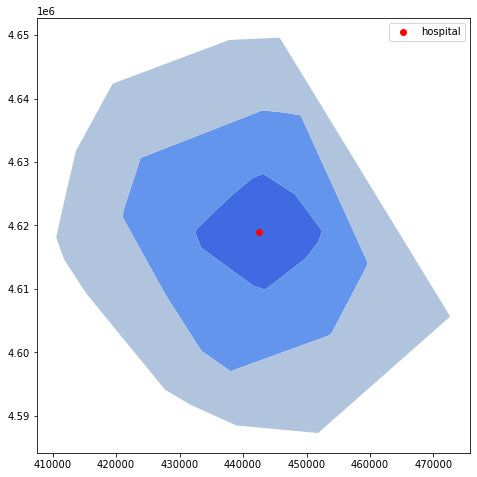

In [29]:
# Create point geometries for entire graph
# what is the pupose of the following two lines? Can this be deleted?
# for node, data in G.nodes(data=True):
#     data['geometry']=Point(data['x'], data['y'])

# which hospital to visualize? 
fighosp = 7

# Create catchment for hospital 0
poly = dijkstra_cca_polygons(G, hospitals['nearest_osm'][fighosp], distances)

# Reproject polygons
for i in range(len(poly)):
    poly[i].crs = { 'init' : 'epsg:4326'}
    poly[i] = poly[i].to_crs({'init':'epsg:32616'})

# Reproject hospitals 
# Possible to map from the hospitals data rather than creating hospital_subset?
hospital_subset = hospitals.iloc[[fighosp]].to_crs(epsg=32616)

fig, ax = plt.subplots(figsize=(12,8))

min_10 = poly[0].plot(ax=ax, color="royalblue", label="10 min drive")
min_20 = poly[1].plot(ax=ax, color="cornflowerblue", label="20 min drive")
min_30 = poly[2].plot(ax=ax, color="lightsteelblue", label="30 min drive")

hospital_subset.plot(ax=ax, color="red", legend=True, label = "hospital")

# Add legend
ax.legend()

In [30]:
poly

[                                            geometry
 0  POLYGON ((443456.283 4609874.589, 441585.172 4...,
                                             geometry
 0  POLYGON ((433443.581 4600237.316, 427780.923 4...,
                                             geometry
 0  POLYGON ((438932.445 4588484.312, 431706.358 4...]

### Calculate hospital catchment areas

In [31]:
%%time
catchments = measure_acc_par(hospitals, pop_data, G, distances, weights, num_proc=processor_dropdown.value)

Calculating 66 hospital catchments...
completed number: 0 5 15 10 1 16 6 11 2 12 7 17 3 8 18 13 4 9 19 14 20 30 25 35 21 31 26 36 22 32 27 37 23 28 33 38 24 34 29 39 40 45 50 55 41 46 51 56 42 47 52 57 48 43 58 53 49 44 54 59 65 60 61 62 63 64 CPU times: user 4.05 s, sys: 1.3 s, total: 5.34 s
Wall time: 3min 10s


### Calculate accessibility

In [32]:
%%time
for j in range(len(catchments)):
    catchments[j] = catchments[j][catchments[j][resource_dropdown.value]!=float('inf')]
result=overlapping_function(grid_file, catchments, resource_dropdown.value, weights, num_proc=processor_dropdown.value)
result

CPU times: user 11.2 s, sys: 1.12 s, total: 12.3 s
Wall time: 35 s


,left,top,right,bottom,id,area,geometry,hospital_icu_beds
0,440843.416087,4.638515e+06,441420.766356,4.638015e+06,4158,216661.173,"POLYGON ((440843.416 4638265.403, 440987.754 4...",0.003546
1,440843.416087,4.638015e+06,441420.766356,4.637515e+06,4159,216661.168,"POLYGON ((440843.416 4637765.403, 440987.754 4...",0.003638
2,440843.416087,4.639515e+06,441420.766356,4.639015e+06,4156,216661.169,"POLYGON ((440843.416 4639265.403, 440987.754 4...",0.003638
3,440843.416087,4.639015e+06,441420.766356,4.638515e+06,4157,216661.171,"POLYGON ((440843.416 4638765.403, 440987.754 4...",0.003574
4,440843.416087,4.640515e+06,441420.766356,4.640015e+06,4154,216661.171,"POLYGON ((440843.416 4640265.403, 440987.754 4...",0.003721
...,...,...,...,...,...,...,...,...
3274,440843.416087,4.643015e+06,441420.766356,4.642515e+06,4149,216661.175,"POLYGON ((440843.416 4642765.403, 440987.754 4...",0.003569
3275,440843.416087,4.644515e+06,441420.766356,4.644015e+06,4146,216661.183,"POLYGON ((440843.416 4644265.403, 440987.754 4...",0.003480
3276,440843.416087,4.644015e+06,441420.766356,4.643515e+06,4147,216661.155,"POLYGON ((440843.416 4643765.403, 440987.754 4...",0.003480
3277,440843.416087,4.645515e+06,441420.766356,4.645015e+06,4144,216661.179,"POLYGON ((440843.416 4645265.403, 440987.754 4...",0.003429


In [33]:
%%time
result = normalization (result, resource_dropdown.value)

CPU times: user 5.45 ms, sys: 1.04 ms, total: 6.49 ms
Wall time: 5.41 ms


In [34]:
result.head()

,left,top,right,bottom,id,area,geometry,hospital_icu_beds
0,440843.416087,4.638515e+06,441420.766356,4.638015e+06,4158,216661.173,"POLYGON ((440843.416 4638265.403, 440987.754 4...",0.903274
1,440843.416087,4.638015e+06,441420.766356,4.637515e+06,4159,216661.168,"POLYGON ((440843.416 4637765.403, 440987.754 4...",0.929614
2,440843.416087,4.639515e+06,441420.766356,4.639015e+06,4156,216661.169,"POLYGON ((440843.416 4639265.403, 440987.754 4...",0.929785
3,440843.416087,4.639015e+06,441420.766356,4.638515e+06,4157,216661.171,"POLYGON ((440843.416 4638765.403, 440987.754 4...",0.911208
4,440843.416087,4.640515e+06,441420.766356,4.640015e+06,4154,216661.171,"POLYGON ((440843.416 4640265.403, 440987.754 4...",0.953645


## New AWR approach

In [35]:
# add weight field to each catchment polygon
for i in range(len(weights)):
    catchments[i]['weight'] = weights[i]
# combine the three sets of catchment polygons into one geodataframe
geocatchments = pd.concat([catchments[0], catchments[1], catchments[2]])
geocatchments


,geometry,time,total_pop,hospital_icu_beds,hospital_vents,weight
0,"POLYGON ((446359.955 4637144.048, 444654.345 4...",600,789023.74,0.000046,0.000015,1.00
0,"POLYGON ((438353.601 4609853.779, 432065.727 4...",600,717916.38,0.000273,0.000089,1.00
0,"POLYGON ((442878.135 4648745.067, 441056.875 4...",600,469346.52,0.000190,0.000062,1.00
0,"POLYGON ((423900.989 4621140.151, 421031.920 4...",600,732753.60,0.000089,0.000029,1.00
0,"POLYGON ((443322.063 4615428.578, 438387.446 4...",600,716375.12,0.000092,0.000029,1.00
...,...,...,...,...,...,...
0,"POLYGON ((440431.675 4605335.203, 415910.447 4...",1800,1015836.64,0.000027,0.000009,0.22
0,"MULTIPOLYGON (((418680.569 4620247.323, 411754...",1800,754080.60,0.000060,0.000019,0.22
0,"POLYGON ((421589.871 4617483.974, 415910.447 4...",1800,973822.96,0.000086,0.000028,0.22
0,"POLYGON ((438852.888 4603453.515, 415910.447 4...",1800,936876.30,0.000065,0.000021,0.22


In [36]:
%%time
# set weighted to False for original 50% threshold method
# switch to True for area-weighted overlay
weighted = True

# if the value to be calculated is already in the hegaxon grid, delete it
# otherwise, the field name gets a suffix _1 in the overlay step
if resource_dropdown.value in list(grid_file.columns.values):
    grid_file = grid_file.drop(resource_dropdown.value, axis = 1)
    
# calculate hexagon 'target' areas
grid_file['area'] = grid_file.area
    
# Intersection overlay of hospital catchments and hexagon grid
print("Intersecting hospital catchments with hexagon grid...")
fragments = gpd.overlay(grid_file, geocatchments, how='intersection')

# Calculate percent coverage of the hexagon by the hospital catchment as
# fragment area / target(hexagon) area
fragments['percent'] = fragments.area / fragments['area']

# if using weighted aggregation... 
if weighted:
    print("Calculating area-weighted value...")
    # multiply the service/population ratio by the distance weight and the percent coverage
    fragments['value'] = fragments[resource_dropdown.value] * fragments['weight'] * fragments['percent']

# if using the 50% coverage rule for unweighted aggregation...
else:
    print("Calculating value for hexagons with >=50% overlap...")
    # filter for only the fragments with > 50% coverage by hospital catchment
    fragments = fragments[fragments['percent']>=0.5]
    # multiply the service/population ration by the distance weight
    fragments['value'] = fragments[resource_dropdown.value] * fragments['weight']

# select just the hexagon id and value from the fragments,
# group the fragments by the (hexagon) id,
# and sum the values
print("Summarizing results by hexagon id...")
sum_results = fragments[['id', 'value']].groupby(by = ['id']).sum()

# join the results to the hexagon grid_file based on hexagon id
print("Joining results to hexagons...")
result_new = pd.merge(grid_file, sum_results, how="left", on = "id")

# rename value column name to the resource name
result_new = result_new.rename(columns = {'value' : resource_dropdown.value})

result_new

Intersecting hospital catchments with hexagon grid...
Calculating area-weighted value...
Summarizing results by hexagon id...
Joining results to hexagons...
CPU times: user 13.9 s, sys: 147 ms, total: 14.1 s
Wall time: 14.1 s


,left,top,right,bottom,id,area,geometry,hospital_icu_beds
0,440843.416087,4.638515e+06,441420.766356,4.638015e+06,4158,216506.350946,"POLYGON ((440843.416 4638265.403, 440987.754 4...",0.003564
1,440843.416087,4.638015e+06,441420.766356,4.637515e+06,4159,216506.350946,"POLYGON ((440843.416 4637765.403, 440987.754 4...",0.003617
2,440843.416087,4.639515e+06,441420.766356,4.639015e+06,4156,216506.350946,"POLYGON ((440843.416 4639265.403, 440987.754 4...",0.003626
3,440843.416087,4.639015e+06,441420.766356,4.638515e+06,4157,216506.350946,"POLYGON ((440843.416 4638765.403, 440987.754 4...",0.003567
4,440843.416087,4.640515e+06,441420.766356,4.640015e+06,4154,216506.350946,"POLYGON ((440843.416 4640265.403, 440987.754 4...",0.003676
...,...,...,...,...,...,...,...,...
3274,440843.416087,4.643015e+06,441420.766356,4.642515e+06,4149,216506.350946,"POLYGON ((440843.416 4642765.403, 440987.754 4...",0.003583
3275,440843.416087,4.644515e+06,441420.766356,4.644015e+06,4146,216506.350946,"POLYGON ((440843.416 4644265.403, 440987.754 4...",0.003473
3276,440843.416087,4.644015e+06,441420.766356,4.643515e+06,4147,216506.350946,"POLYGON ((440843.416 4643765.403, 440987.754 4...",0.003499
3277,440843.416087,4.645515e+06,441420.766356,4.645015e+06,4144,216506.350946,"POLYGON ((440843.416 4645265.403, 440987.754 4...",0.003427


In [37]:
%%time
result_new = normalization (result_new, (resource_dropdown.value))

CPU times: user 2.31 ms, sys: 7 µs, total: 2.32 ms
Wall time: 2.05 ms


## Results from AWR

In [38]:
# New result using AWR
result_new.head()

,left,top,right,bottom,id,area,geometry,hospital_icu_beds
0,440843.416087,4.638515e+06,441420.766356,4.638015e+06,4158,216506.350946,"POLYGON ((440843.416 4638265.403, 440987.754 4...",0.914755
1,440843.416087,4.638015e+06,441420.766356,4.637515e+06,4159,216506.350946,"POLYGON ((440843.416 4637765.403, 440987.754 4...",0.930463
2,440843.416087,4.639515e+06,441420.766356,4.639015e+06,4156,216506.350946,"POLYGON ((440843.416 4639265.403, 440987.754 4...",0.932954
3,440843.416087,4.639015e+06,441420.766356,4.638515e+06,4157,216506.350946,"POLYGON ((440843.416 4638765.403, 440987.754 4...",0.915788
4,440843.416087,4.640515e+06,441420.766356,4.640015e+06,4154,216506.350946,"POLYGON ((440843.416 4640265.403, 440987.754 4...",0.947805


## Results from original 50% threshold

In [39]:
result.head()

,left,top,right,bottom,id,area,geometry,hospital_icu_beds
0,440843.416087,4.638515e+06,441420.766356,4.638015e+06,4158,216661.173,"POLYGON ((440843.416 4638265.403, 440987.754 4...",0.903274
1,440843.416087,4.638015e+06,441420.766356,4.637515e+06,4159,216661.168,"POLYGON ((440843.416 4637765.403, 440987.754 4...",0.929614
2,440843.416087,4.639515e+06,441420.766356,4.639015e+06,4156,216661.169,"POLYGON ((440843.416 4639265.403, 440987.754 4...",0.929785
3,440843.416087,4.639015e+06,441420.766356,4.638515e+06,4157,216661.171,"POLYGON ((440843.416 4638765.403, 440987.754 4...",0.911208
4,440843.416087,4.640515e+06,441420.766356,4.640015e+06,4154,216661.171,"POLYGON ((440843.416 4640265.403, 440987.754 4...",0.953645


## Difference between the two

In [41]:
# Difference is AWR approach - 50% threshold approach
diff = pd.DataFrame({
    'column_id': result_new['id'],
    'geometry': result_new['geometry'],
    'hospital_icu_beds_result_new': result_new[resource_dropdown.value],
    'hospital_icu_beds_result': result[resource_dropdown.value],
    'difference': result_new[resource_dropdown.value] - result[resource_dropdown.value]
})

diff

,column_id,geometry,hospital_icu_beds_result_new,hospital_icu_beds_result,difference
0,4158,"POLYGON ((440843.416 4638265.403, 440987.754 4...",0.914755,0.903274,0.011481
1,4159,"POLYGON ((440843.416 4637765.403, 440987.754 4...",0.930463,0.929614,0.000849
2,4156,"POLYGON ((440843.416 4639265.403, 440987.754 4...",0.932954,0.929785,0.003169
3,4157,"POLYGON ((440843.416 4638765.403, 440987.754 4...",0.915788,0.911208,0.004581
4,4154,"POLYGON ((440843.416 4640265.403, 440987.754 4...",0.947805,0.953645,-0.005840
...,...,...,...,...,...
3274,4149,"POLYGON ((440843.416 4642765.403, 440987.754 4...",0.920515,0.909959,0.010556
3275,4146,"POLYGON ((440843.416 4644265.403, 440987.754 4...",0.888255,0.884215,0.004040
3276,4147,"POLYGON ((440843.416 4643765.403, 440987.754 4...",0.895978,0.884215,0.011764
3277,4144,"POLYGON ((440843.416 4645265.403, 440987.754 4...",0.874803,0.869461,0.005342


In [42]:
pd.set_option('display.float_format', '{:.10f}'.format)

result_new.hospital_icu_beds 

0      0.9147547364
1      0.9304634378
2      0.9329544297
3      0.9157883242
4      0.9478047543
           ...     
3274   0.9205149708
3275   0.8882549218
3276   0.8959781608
3277   0.8748030804
3278   0.8799557428
Name: hospital_icu_beds, Length: 3279, dtype: float64

In [43]:
result.hospital_icu_beds

0      0.9032740792
1      0.9296141212
2      0.9297851328
3      0.9112075113
4      0.9536450358
           ...     
3274   0.9099586646
3275   0.8842145142
3276   0.8842145142
3277   0.8694608955
3278   0.8728246317
Name: hospital_icu_beds, Length: 3279, dtype: float64

### Results & Discussion

OSMNX assigns speedlimits to roads with unknown speed limits based on

Depends on overestimation or underestimation of speed limit

This is a threat to spatial heterogeneity

### Accessibility Map (50% threshold)

CPU times: user 3.95 s, sys: 409 ms, total: 4.36 s
Wall time: 3.99 s


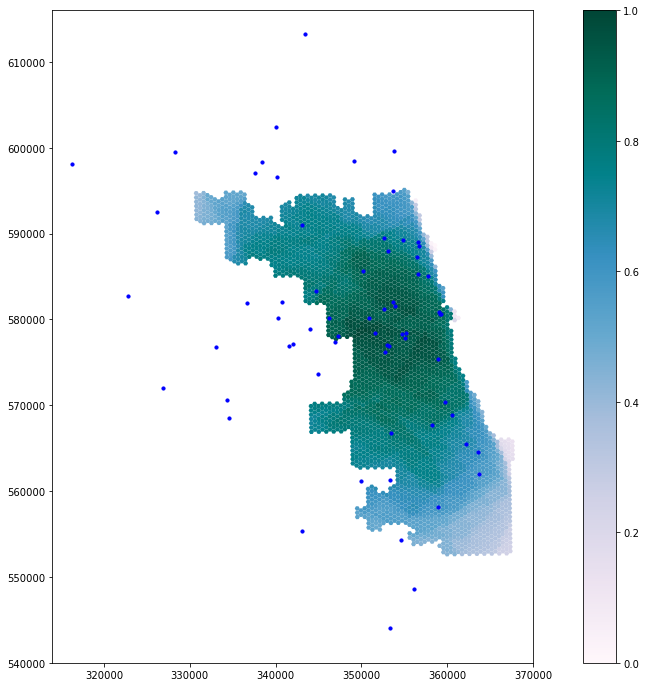

In [44]:
%%time
hospitals = hospitals.to_crs({'init': 'epsg:26971'})
result = result.to_crs({'init': 'epsg:26971'})
output_map(result, pop_data, hospitals, resource_dropdown.value)

### Accessibility Map (AWR)

CPU times: user 2.46 s, sys: 181 ms, total: 2.64 s
Wall time: 2.42 s


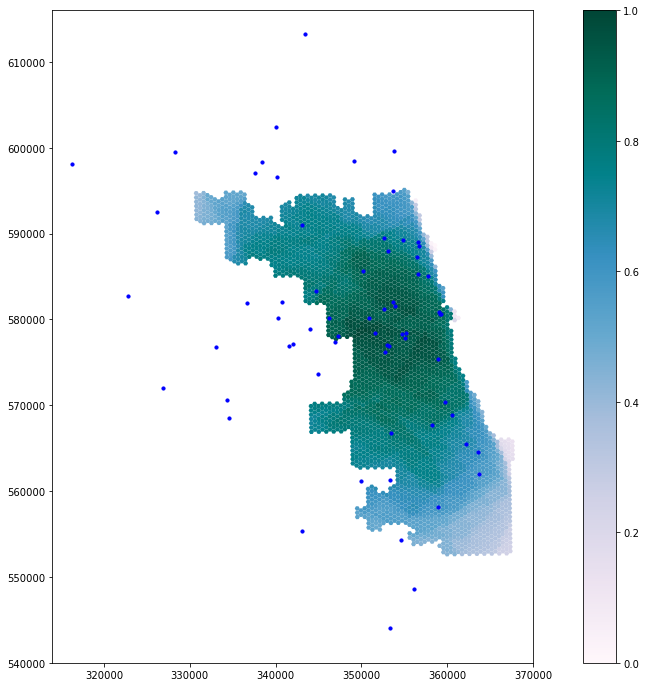

In [45]:
%%time
hospitals = hospitals.to_crs({'init': 'epsg:26971'})
result_new = result.to_crs({'init': 'epsg:26971'})
output_map(result_new, pop_data, hospitals, resource_dropdown.value)

In [46]:
# Merge the two GeoDataFrames based on their geometry
merged = pd.merge(result, result_new, how='inner', left_on='geometry', right_on='geometry')
merged

# _x suffix indicates from results (50% threshold), and _y indicates from results_new (AWR approach)


# Calculate the difference of the variable of interest between the 50% threshold and AWR approach
merged['hospital_icu_beds_diff'] = merged['hospital_icu_beds_x'] - merged['hospital_icu_beds_y']
merged

# Create a new GeoDataFrame with the desired columns
#hexagon_diff = merged[['left_x', 'top_x', 'right_x', 'bottom_x', 'id_x', 'area_x', 'geometry', 'hospital_icu_beds_diff']]

# Optionally, you can set the CRS of the new GeoDataFrame
#hexagon_diff.crs = {'init': 'epsg:26971'}

#hexagon_diff

#output_map(merged, pop_data, hospitals, hospital_icu_beds_diff)  #output_grid, base_map, hospitals, resource

# Print the new GeoDataFrame
#print(hexagon_diff)

,left_x,top_x,right_x,bottom_x,id_x,area_x,geometry,hospital_icu_beds_x,left_y,top_y,right_y,bottom_y,id_y,area_y,hospital_icu_beds_y,hospital_icu_beds_diff
0,440843.4160873027,4638515.4028352341,441420.7663564924,4638015.4028352341,4158,216661.1730000000,"POLYGON ((351469.371 580527.566, 351609.858 58...",0.9032740792,440843.4160873027,4638515.4028352341,441420.7663564924,4638015.4028352341,4158,216661.1730000000,0.9032740792,0.0000000000
1,440843.4160873027,4638015.4028352341,441420.7663564924,4637515.4028352341,4159,216661.1680000000,"POLYGON ((351477.143 580027.445, 351617.630 58...",0.9296141212,440843.4160873027,4638015.4028352341,441420.7663564924,4637515.4028352341,4159,216661.1680000000,0.9296141212,0.0000000000
2,440843.4160873027,4639515.4028352341,441420.7663564924,4639015.4028352341,4156,216661.1690000000,"POLYGON ((351453.825 581527.810, 351594.311 58...",0.9297851328,440843.4160873027,4639515.4028352341,441420.7663564924,4639015.4028352341,4156,216661.1690000000,0.9297851328,0.0000000000
3,440843.4160873027,4639015.4028352341,441420.7663564924,4638515.4028352341,4157,216661.1710000000,"POLYGON ((351461.598 581027.688, 351602.085 58...",0.9112075113,440843.4160873027,4639015.4028352341,441420.7663564924,4638515.4028352341,4157,216661.1710000000,0.9112075113,0.0000000000
4,440843.4160873027,4640515.4028352341,441420.7663564924,4640015.4028352341,4154,216661.1710000000,"POLYGON ((351438.276 582528.054, 351578.761 58...",0.9536450358,440843.4160873027,4640515.4028352341,441420.7663564924,4640015.4028352341,4154,216661.1710000000,0.9536450358,0.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,440843.4160873027,4643015.4028352341,441420.7663564924,4642515.4028352341,4149,216661.1750000000,"POLYGON ((351399.392 585028.663, 351539.875 58...",0.9099586646,440843.4160873027,4643015.4028352341,441420.7663564924,4642515.4028352341,4149,216661.1750000000,0.9099586646,0.0000000000
3275,440843.4160873027,4644515.4028352341,441420.7663564924,4644015.4028352341,4146,216661.1830000000,"POLYGON ((351376.053 586529.029, 351516.536 58...",0.8842145142,440843.4160873027,4644515.4028352341,441420.7663564924,4644015.4028352341,4146,216661.1830000000,0.8842145142,0.0000000000
3276,440843.4160873027,4644015.4028352341,441420.7663564924,4643515.4028352341,4147,216661.1550000000,"POLYGON ((351383.833 586028.907, 351524.316 58...",0.8842145142,440843.4160873027,4644015.4028352341,441420.7663564924,4643515.4028352341,4147,216661.1550000000,0.8842145142,0.0000000000
3277,440843.4160873027,4645515.4028352341,441420.7663564924,4645015.4028352341,4144,216661.1790000000,"POLYGON ((351360.491 587529.272, 351500.972 58...",0.8694608955,440843.4160873027,4645515.4028352341,441420.7663564924,4645015.4028352341,4144,216661.1790000000,0.8694608955,0.0000000000


Classified Accessibility Outputs

### Conclusion

to be written.

### References

Luo, W., & Qi, Y. (2009). An enhanced two-step floating catchment area (E2SFCA) method for measuring spatial accessibility to primary care physicians. Health & place, 15(4), 1100-1107.